In [ ]:
import os
import yaml
from tqdm import tqdm

def collect_attackee_results(folder_path):
    results_dict = {}
    yaml_paths = []
    # Get all first-level subfolders
    first_level_subfolders = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    for subfolder in tqdm(first_level_subfolders):
        subfolder_path = os.path.join(folder_path, subfolder)
        # Get all second-level subfolders matching the pattern
        second_level_subfolders = [d for d in os.listdir(subfolder_path) if os.path.isdir(os.path.join(subfolder_path, d))]
        for lower_subfolder in second_level_subfolders:
            results_yaml_path = os.path.join(subfolder_path, lower_subfolder, 'results', 'attackee_results.yaml')
            if os.path.exists(results_yaml_path):
                yaml_paths.append((subfolder, lower_subfolder, results_yaml_path))
    # Load all data
    for subfolder, lower_subfolder, results_yaml_path in tqdm(yaml_paths):
        try:
            with open(results_yaml_path, 'r') as f:
                yaml_content = yaml.load(f, Loader=yaml.CLoader)
            if subfolder not in results_dict:
                results_dict[subfolder] = {}
            results_dict[subfolder][lower_subfolder] = yaml_content
        except:
            print(f"Error reading {results_yaml_path}, skipping.")
            continue
    return results_dict

In [11]:
base_path = "/vol/miltank/users/kaiserj/Clipping_vs_Sampling/budget_adv_final"
results = collect_attackee_results(base_path)
print("")

  0%|          | 0/371 [00:00<?, ?it/s]

100%|██████████| 750/750 [1:03:48<00:00,  5.10s/it]


In [12]:
aggregated = {}
for idx in results:
    for label in results[idx]:
        if label not in aggregated:
            aggregated[label] = []
        values = results[idx][label].get('adv_attackee', [])
        aggregated[label].extend(values)


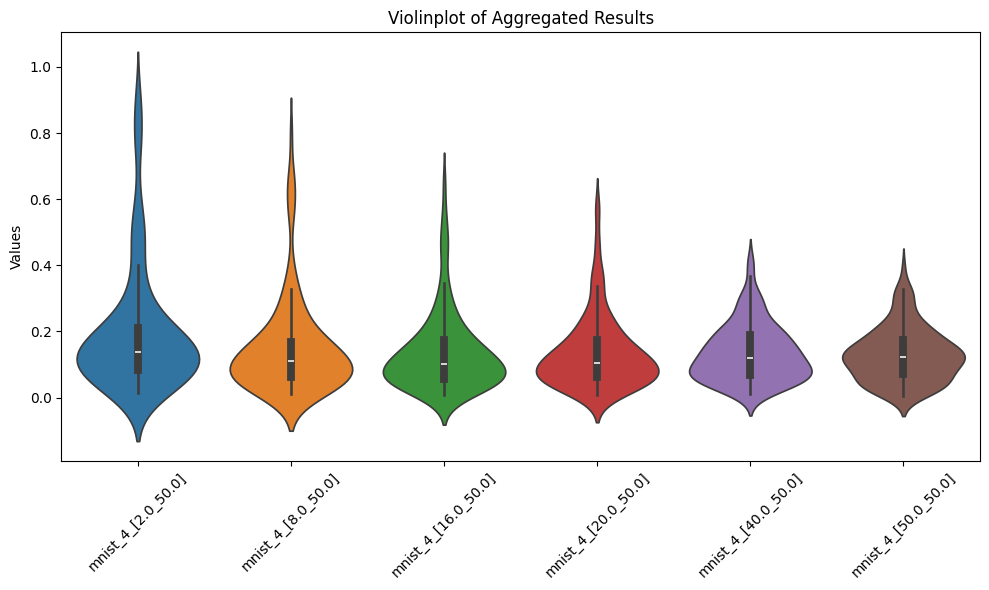

In [13]:
print("")
print("")
import matplotlib.pyplot as plt
import seaborn as sns

order = [
    'mnist_4_[2.0_50.0]',
    'mnist_4_[8.0_50.0]',
    'mnist_4_[16.0_50.0]',
    'mnist_4_[20.0_50.0]',
    'mnist_4_[40.0_50.0]',
    'mnist_4_[50.0_50.0]'
]

plt.figure(figsize=(10, 6))
sns.violinplot(data=[aggregated[k] for k in order])
plt.xticks(ticks=range(len(order)), labels=order, rotation=45)
plt.ylabel("Values")
plt.title("Violinplot of Aggregated Results")
plt.tight_layout()
plt.show()

/tmp/ipykernel_229980/1582796885.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


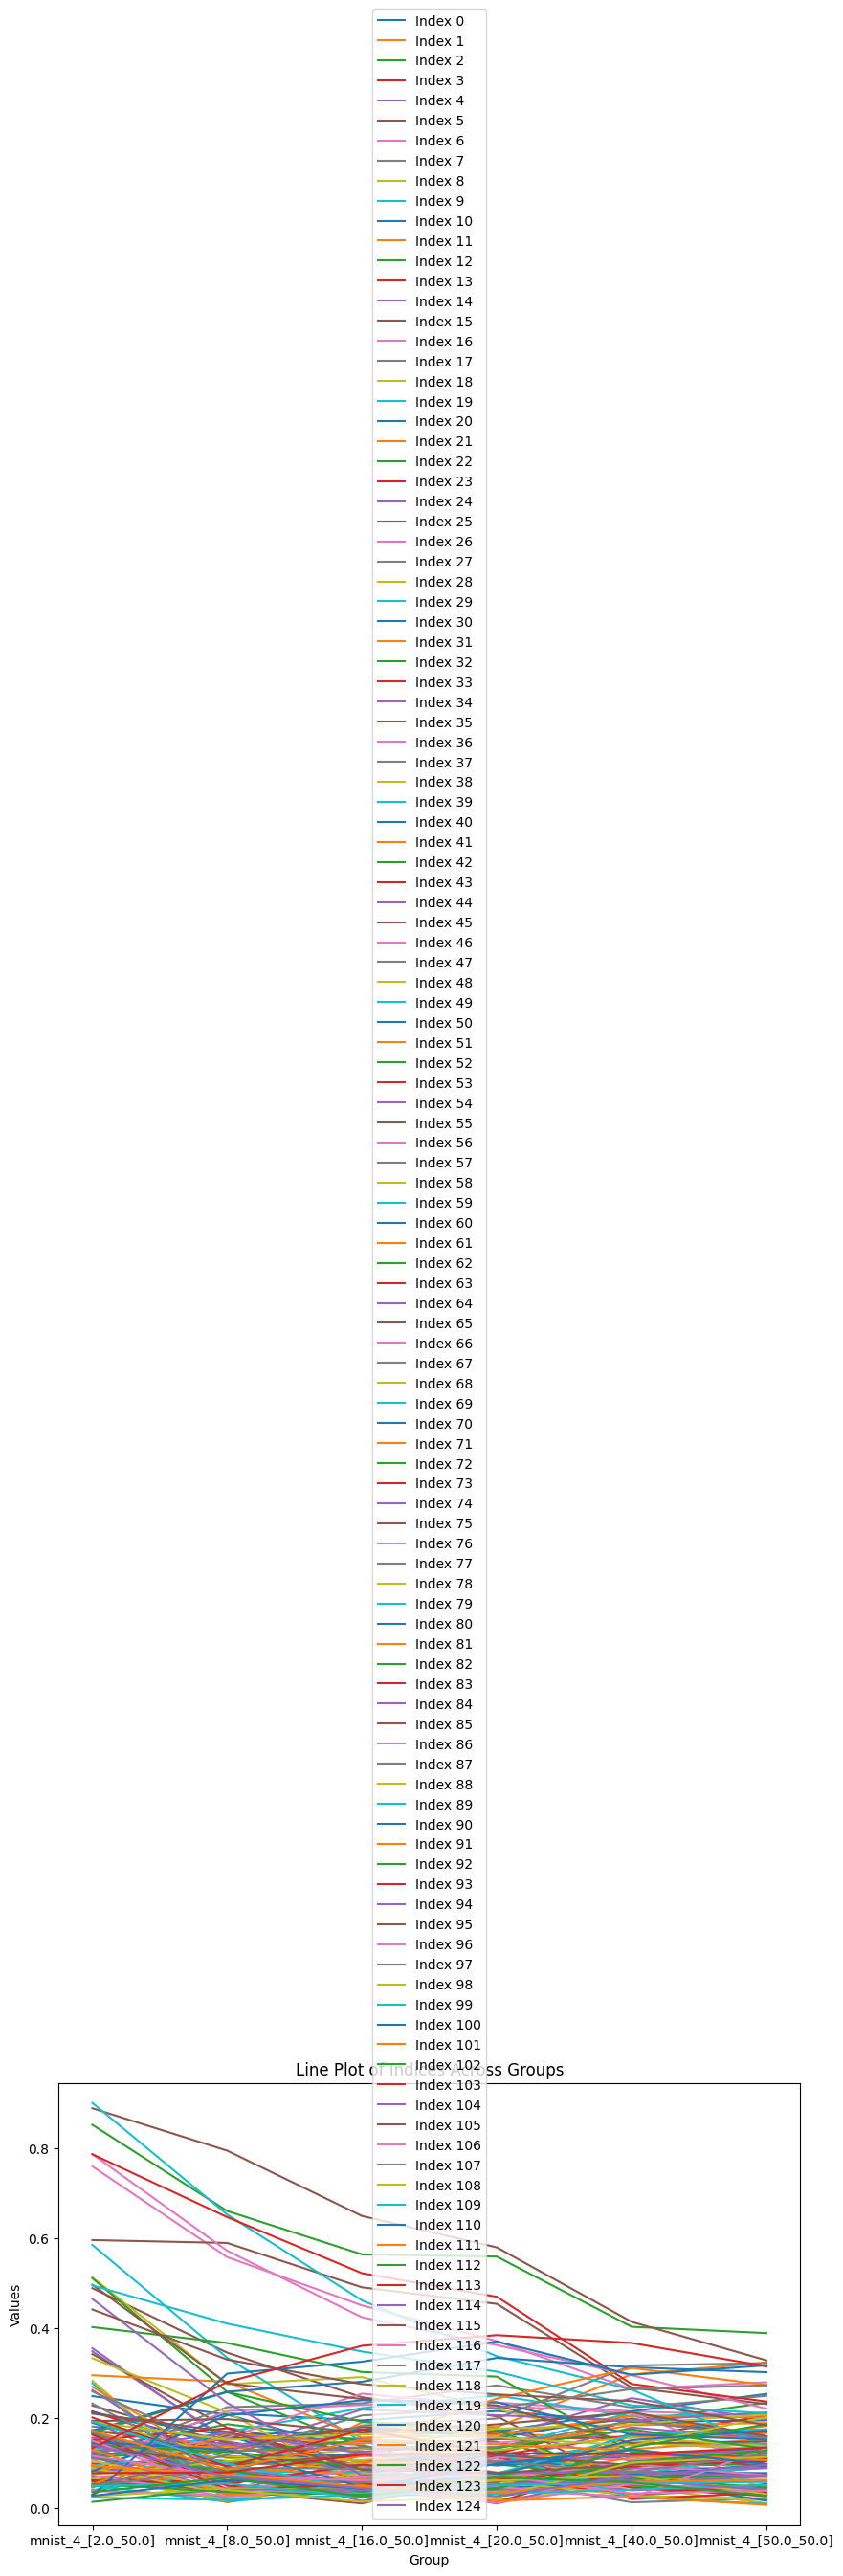

In [14]:
import numpy as np

# Find the minimum length among all groups to align indices
min_len = min(len(aggregated[k]) for k in order)

# Stack values for each index across all groups
data = np.array([aggregated[k][:min_len] for k in order])  # shape: (groups, min_len)

plt.figure(figsize=(10, 6))
for idx in range(min_len):
    plt.plot(order, data[:, idx], label=f'Index {idx}')
plt.xlabel("Group")
plt.ylabel("Values")
plt.title("Line Plot of Indices Across Groups")
plt.legend()
plt.tight_layout()
plt.show()

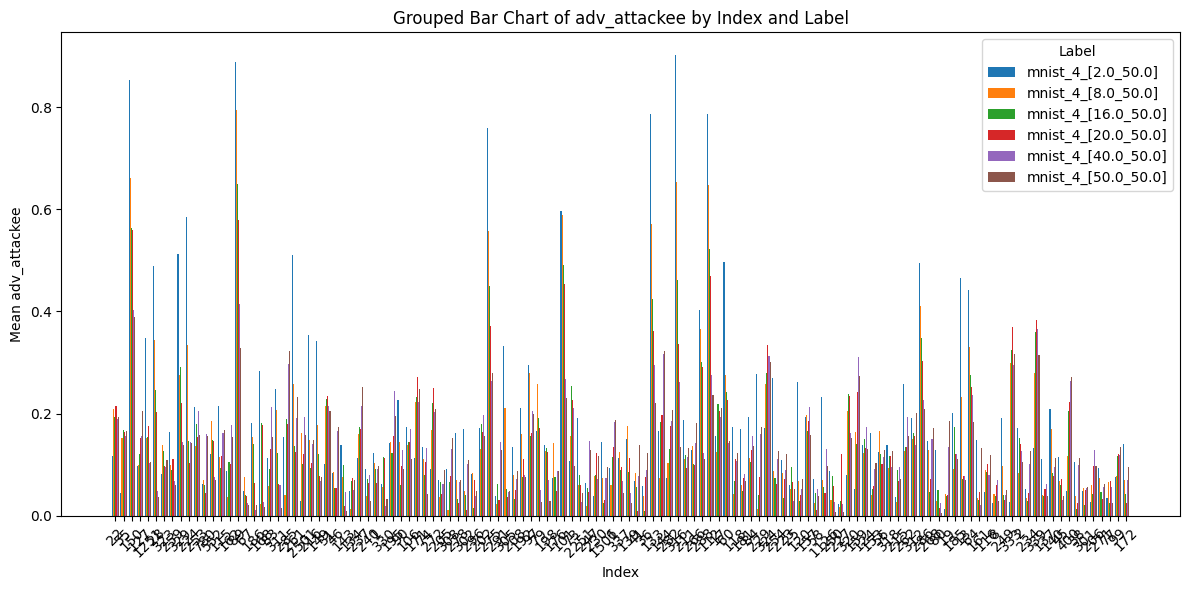

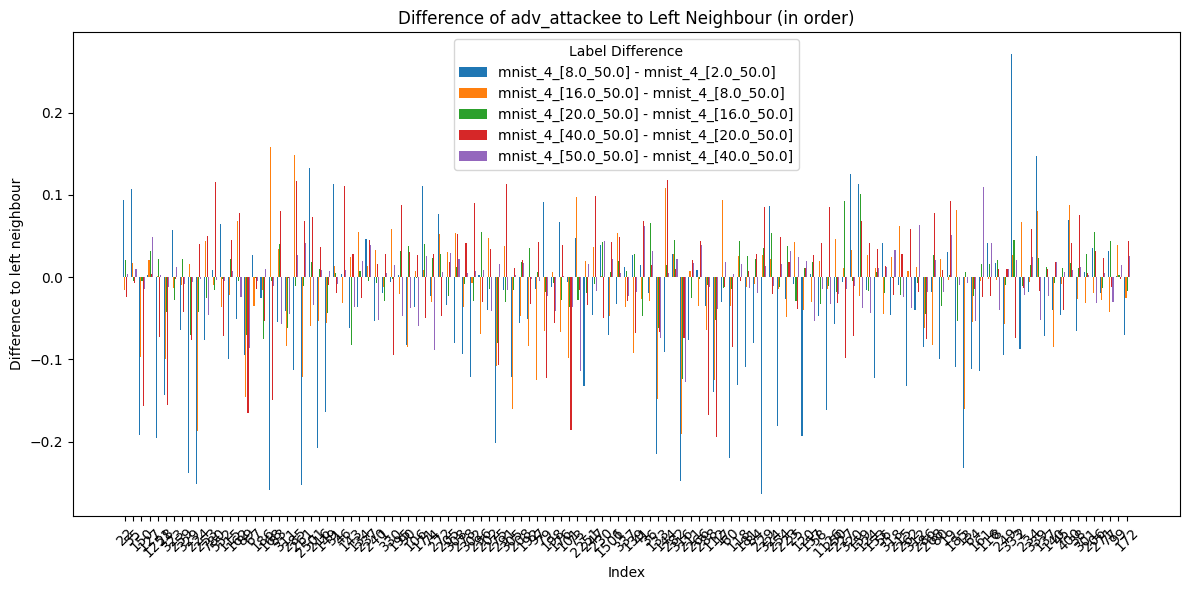

In [15]:
import numpy as np

import matplotlib.pyplot as plt

# Prepare data for grouped bar chart
indices = list(results.keys())
labels = order  # use the specified order
num_indices = len(indices)
num_labels = len(labels)

# Collect adv_attackee values for each index and label
bar_data = []
for idx in indices:
    group = []
    for label in labels:
        group.append(np.mean(results[idx][label]['adv_attackee']) if label in results[idx] and 'adv_attackee' in results[idx][label] else np.nan)
    bar_data.append(group)
bar_data = np.array(bar_data)  # shape: (num_indices, num_labels)

# Plot 1: Grouped Bar Chart
x = np.arange(num_indices)
bar_width = 0.13
plt.figure(figsize=(12, 6))
for i, label in enumerate(labels):
    plt.bar(x + i * bar_width, bar_data[:, i], width=bar_width, label=label)

plt.xticks(x + bar_width * (num_labels - 1) / 2, indices, rotation=45)
plt.xlabel("Index")
plt.ylabel("Mean adv_attackee")
plt.title("Grouped Bar Chart of adv_attackee by Index and Label")
plt.legend(title="Label")
plt.tight_layout()
plt.show()

# Plot 2: Difference to left neighbour in group
diffs = np.full_like(bar_data, np.nan)
diffs[:, 1:] = bar_data[:, 1:] - bar_data[:, :-1]

plt.figure(figsize=(12, 6))
for i, label in enumerate(labels):
    if i == 0:
        continue  # skip first column, no left neighbour
    plt.bar(x + i * bar_width, diffs[:, i], width=bar_width, label=f"{labels[i]} - {labels[i-1]}")

plt.xticks(x + bar_width * (num_labels - 1) / 2, indices, rotation=45)
plt.xlabel("Index")
plt.ylabel("Difference to left neighbour")
plt.title("Difference of adv_attackee to Left Neighbour (in order)")
plt.legend(title="Label Difference")
plt.tight_layout()
plt.show()


In [16]:
import numpy as np
from scipy import stats

# Compute differences to next in order for each row in bar_data
# (i.e., for each index, subtract each label's value from the next label's value in 'order')
next_diffs = np.full((bar_data.shape[0], bar_data.shape[1] - 1), np.nan)
for i in range(bar_data.shape[0]):
    for j in range(bar_data.shape[1] - 1):
        if not np.isnan(bar_data[i, j]) and not np.isnan(bar_data[i, j + 1]):
            next_diffs[i, j] = bar_data[i, j + 1] - bar_data[i, j]

# Flatten and remove nan for statistical tests
flat_diffs = next_diffs[~np.isnan(next_diffs)]

# 1. One-sample t-test: Test if the mean of differences is less than zero
# Null hypothesis: mean == 0; Alternative: mean < 0
t_stat, t_pvalue = stats.ttest_1samp(flat_diffs, popmean=0, alternative='less')
# If p-value < 0.05, we reject the null hypothesis and conclude the mean is likely negative

# 2. Wilcoxon signed-rank test: Non-parametric test for median < 0
# Null hypothesis: median == 0; Alternative: median < 0
wilcoxon_stat, wilcoxon_pvalue = stats.wilcoxon(flat_diffs, alternative='less', zero_method='wilcox')
# If p-value < 0.05, we reject the null hypothesis and conclude the median is likely negative

# 3. Binomial test: Count how many diffs are negative vs positive
num_neg = np.sum(flat_diffs < 0)
num_pos = np.sum(flat_diffs > 0)
num_total = num_neg + num_pos
binom_pvalue = stats.binomtest(num_neg, n=num_total, p=0.5, alternative='greater')
# If p-value < 0.05, more negatives than positives than expected by chance

# Print results
print("# One-sample t-test for mean < 0")
print(f"t-statistic: {t_stat:.4f}, p-value: {t_pvalue:.4g}")

print("# Wilcoxon signed-rank test for median < 0")
print(f"Wilcoxon statistic: {wilcoxon_stat:.4f}, p-value: {wilcoxon_pvalue:.4g}")

print("# Binomial test for more negatives than positives")
print(f"Negative diffs: {num_neg}, Positive diffs: {num_pos}, p-value: {binom_pvalue}")

# Interpretation:
# If any p-value < 0.05, you have statistical evidence that the differences are more likely negative than positive.
# t-test assumes normality, Wilcoxon is non-parametric, Binomial is a simple sign test.

# One-sample t-test for mean < 0
t-statistic: -5.0838, p-value: 2.448e-07
# Wilcoxon signed-rank test for median < 0
Wilcoxon statistic: 80546.0000, p-value: 6.58e-05
# Binomial test for more negatives than positives
Negative diffs: 343, Positive diffs: 282, p-value: BinomTestResult(k=343, n=625, alternative='greater', statistic=0.5488, pvalue=0.008163382256745472)


In [17]:
# Compute differences between last and first label for each index in bar_data
last_first_diffs = bar_data[:, -1] - bar_data[:, 0]

# Remove nan for statistical tests
flat_last_first_diffs = last_first_diffs[~np.isnan(last_first_diffs)]

# 1. One-sample t-test: Test if the mean of differences is less than zero
t_stat_lf, t_pvalue_lf = stats.ttest_1samp(flat_last_first_diffs, popmean=0, alternative='less')

# 2. Wilcoxon signed-rank test: Non-parametric test for median < 0
wilcoxon_stat_lf, wilcoxon_pvalue_lf = stats.wilcoxon(flat_last_first_diffs, alternative='less', zero_method='wilcox')

# 3. Binomial test: Count how many diffs are negative vs positive
num_neg_lf = np.sum(flat_last_first_diffs < 0)
num_pos_lf = np.sum(flat_last_first_diffs > 0)
num_total_lf = num_neg_lf + num_pos_lf
binom_pvalue_lf = stats.binomtest(num_neg_lf, n=num_total_lf, p=0.5, alternative='greater')

# Print results
print("# One-sample t-test for mean < 0 (last - first)")
print(f"t-statistic: {t_stat_lf:.4f}, p-value: {t_pvalue_lf:.4g}")

print("# Wilcoxon signed-rank test for median < 0 (last - first)")
print(f"Wilcoxon statistic: {wilcoxon_stat_lf:.4f}, p-value: {wilcoxon_pvalue_lf:.4g}")

print("# Binomial test for more negatives than positives (last - first)")
print(f"Negative diffs: {num_neg_lf}, Positive diffs: {num_pos_lf}, p-value: {binom_pvalue_lf}")

# One-sample t-test for mean < 0 (last - first)
t-statistic: -4.1279, p-value: 3.334e-05
# Wilcoxon signed-rank test for median < 0 (last - first)
Wilcoxon statistic: 2608.0000, p-value: 0.0005268
# Binomial test for more negatives than positives (last - first)
Negative diffs: 77, Positive diffs: 48, p-value: BinomTestResult(k=77, n=125, alternative='greater', statistic=0.616, pvalue=0.005979506761619121)
